In [1]:
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
import numpy as np
import cv2
from torchsummary import summary
#from torchinfo import summary  # Model summary
from torchvision.models import VGG16_Weights
import requests
import zipfile
from tqdm import tqdm  # Progress bara
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Path to your AffectNet dataset
data_path = '/data/leuven/359/vsc35963/maibi_cv/AffectNet'
labels_file = os.path.join(data_path, '/data/leuven/359/vsc35963/maibi_cv/AffectNet/labels.csv')  # Assuming labels are in a CSV file

# Load the dataset
data = pd.read_csv(labels_file)

#VGG16_Weightstaset into features and labels
X = data['pth']
y = data['label']

# Perform an 80-10-10 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create directories for the splits
splits = ['train', 'val', 'test']
for split in splits:
    split_dir = os.path.join(data_path, split)
    os.makedirs(split_dir, exist_ok=True)
    for label in y.unique():
        class_dir = os.path.join(split_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)

# Function to save split data to directories
def save_split_data(X, y, split):
    for img_path, label in zip(X, y):
        src = os.path.join(data_path, img_path)
        dst_dir = os.path.join(data_path, split, str(label))
        dst = os.path.join(dst_dir, os.path.basename(img_path))
        if not os.path.exists(dst):
            shutil.copy(src, dst)  # You can use os.symlink if you prefer symlinking over copying

# Save the splits
save_split_data(X_train, y_train, 'train')
save_split_data(X_val, y_val, 'val')
save_split_data(X_test, y_test, 'test')

print("Data successfully split and saved:")
print(f"Training data saved to {os.path.join(data_path, 'train')}")
print(f"Validation data saved to {os.path.join(data_path, 'val')}")
print(f"Test data saved to {os.path.join(data_path, 'test')}")

Data successfully split and saved:
Training data saved to /data/leuven/359/vsc35963/maibi_cv/AffectNet/train
Validation data saved to /data/leuven/359/vsc35963/maibi_cv/AffectNet/val
Test data saved to /data/leuven/359/vsc35963/maibi_cv/AffectNet/test


In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
#checking existance of directory

# Specify the path to check
directory_path = '/data/leuven/359/vsc35963/maibi_cv/AffectNet/test'

# Check if the directory exists
if os.path.exists(directory_path):
    print("Directory exists.")
else:
    print("Directory does not exist.")

Directory exists.


In [5]:
# Set Paths to the dataset
dataset_path_train = '/data/leuven/359/vsc35963/maibi_cv/AffectNet/train'
dataset_path_val = '/data/leuven/359/vsc35963/maibi_cv/AffectNet/val'
dataset_path_test = '/data/leuven/359/vsc35963/maibi_cv/AffectNet/test'

# Set Parameters for Training
batch_size = 32
epochs = 10
input_shape = (96, 96)

# Define the GaussianBlur transformation for severity level 3
blur_transform = transforms.GaussianBlur(kernel_size=41, sigma=30.0)

# Define data transforms with Gaussian blur
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_shape),
        blur_transform,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_shape),
        blur_transform,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_shape),
        blur_transform,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
train_dataset = datasets.ImageFolder(dataset_path_train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(dataset_path_val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(dataset_path_test, transform=data_transforms['test'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


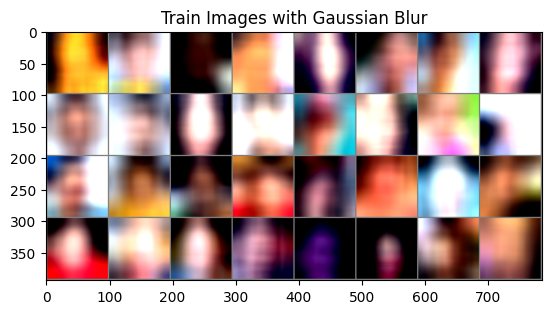

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


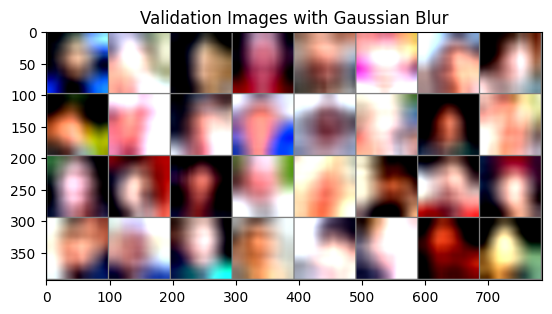

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


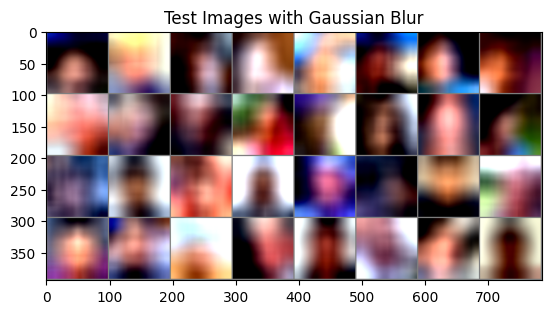

In [6]:
# Function to unnormalize and plot images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Visualize some samples for each set
def visualize_samples(dataloader, set_name):
    # Get a batch of data
    images, labels = next(iter(dataloader))
    
    # Make a grid from batch
    out = torchvision.utils.make_grid(images)
    
    # Display the images
    imshow(out, title=f'{set_name} Images with Gaussian Blur')

# Visualize samples from each dataset
for loader, set_name in [(train_loader, 'Train'), (val_loader, 'Validation'), (test_loader, 'Test')]:
    visualize_samples(loader, set_name)

In [7]:
#import numpy as np
#import matplotlib.pyplot as plt
#import cv2

# def visualize_dataset_samples(dataset, title):
#     # Get classes and class-to-index mapping
#     classes = dataset.classes
#     class_to_idx = dataset.class_to_idx
#     samples_per_class = 5

#     fig, axes = plt.subplots(nrows=len(classes), ncols=samples_per_class, figsize=(15, 2 * len(classes)))
#     fig.suptitle(title, fontsize=16)

#     for i, class_name in enumerate(classes):
#         class_idx = class_to_idx[class_name]
#         # Get samples for the class
#         class_samples = [sample for sample, label in dataset.samples if label == class_idx]
        
#         # Ensure there are enough samples, otherwise skip or reduce sample size
#         if len(class_samples) < samples_per_class:
#             print(f"Warning: Class {class_name} has less than {samples_per_class} samples, using {len(class_samples)} samples.")
#             samples_to_show = class_samples
#         else:
#             samples_to_show = np.random.choice(class_samples, size=samples_per_class, replace=False)
        
#         # Load and display images
#         for j, sample_path in enumerate(samples_to_show):
#             img = cv2.imread(sample_path)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             ax = axes[i, j]
#             ax.imshow(img)
#             ax.axis('off')
#             # Add label overlay on the image
#             ax.text(0.5, -0.1, class_name, transform=ax.transAxes, ha='center', va='top', color='white', fontsize=12, backgroundcolor='black')
#             if j == 0:
#                 ax.set_ylabel(class_name, rotation=0, size='large', labelpad=60)

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.95)  # Adjust subplot to not overlap with title
#     plt.show()

# # Visualize each dataset separately
# visualize_dataset_samples(train_dataset, "Training Dataset Samples")
# visualize_dataset_samples(val_dataset, "Validation Dataset Samples")
# visualize_dataset_samples(test_dataset, "Test Dataset Samples")

In [7]:
# Load the pre-trained VGG16 model
base_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
base_model.classifier = nn.Sequential(
    nn.Linear(base_model.classifier[0].in_features, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, len(train_dataset.classes)),
)

In [8]:
base_model.to(device)

# Freeze the layers of the pre-trained model
for param in base_model.features.parameters():
    param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define specific learning rates 
lr_low = 0.00001  # Lower learning rate for the first classifier layer
lr_high = 0.0001   # Higher learning rate for the last classifier layer


# Set up the optimizer
optimizer = optim.Adam([
    {'params': base_model.classifier[0].parameters(), 'lr': lr_low},
    {'params': base_model.classifier[2].parameters(), 'lr': lr_high}
])


In [9]:
#Learning rate scheduler (optional)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #can be added to avoid local minima

In [10]:
def plot_learning_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'r-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'r-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
# Training and validation loop with progress bar
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                                Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, device=device):
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    early_stopper = EarlyStopping(patience=5, min_delta=0.001)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", position=0, leave=True) as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar.set_postfix({"Loss": running_loss / (pbar.n + 1), "Accuracy": correct / total})
                pbar.update()

        # Compute average losses and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        # Store metrics in history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
        
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print("Early stopping")
            break

    plot_learning_curves(history)  # Call to plot learning curves after training ends or is stopped early
    return model, history

def plot_learning_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'r-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'r-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(loader), correct / total

Epoch 1/14: 100%|██████████| 698/698 [01:03<00:00, 10.95it/s, Loss=1.98, Accuracy=0.236]


Epoch 1/14, Train Loss: 1.9789053958261593, Train Accuracy: 0.23610800161196435, Val Loss: 1.9381309232928536, Val Accuracy: 0.26917613636363635


Epoch 2/14: 100%|██████████| 698/698 [01:02<00:00, 11.20it/s, Loss=1.86, Accuracy=0.305]


Epoch 2/14, Train Loss: 1.8636780442685998, Train Accuracy: 0.3053776922043613, Val Loss: 1.8905144537037069, Val Accuracy: 0.2922585227272727


Epoch 3/14: 100%|██████████| 698/698 [01:02<00:00, 11.17it/s, Loss=1.79, Accuracy=0.338]


Epoch 3/14, Train Loss: 1.792641114881182, Train Accuracy: 0.3376617561456141, Val Loss: 1.8768877576697955, Val Accuracy: 0.30113636363636365


Epoch 4/14: 100%|██████████| 698/698 [01:02<00:00, 11.11it/s, Loss=1.73, Accuracy=0.368]


Epoch 4/14, Train Loss: 1.7337423166777821, Train Accuracy: 0.3683786325169032, Val Loss: 1.8704644333232532, Val Accuracy: 0.30717329545454547


Epoch 5/14: 100%|██████████| 698/698 [01:02<00:00, 11.19it/s, Loss=1.68, Accuracy=0.392]


Epoch 5/14, Train Loss: 1.67879786583619, Train Accuracy: 0.3920655532172122, Val Loss: 1.8715236322446303, Val Accuracy: 0.3014914772727273
EarlyStopping counter: 1 out of 5


Epoch 6/14: 100%|██████████| 698/698 [01:02<00:00, 11.13it/s, Loss=1.63, Accuracy=0.418]


Epoch 6/14, Train Loss: 1.6265412251382299, Train Accuracy: 0.4175883222137644, Val Loss: 1.8700732426209883, Val Accuracy: 0.30078125
EarlyStopping counter: 2 out of 5


Epoch 7/14: 100%|██████████| 698/698 [01:02<00:00, 11.21it/s, Loss=1.58, Accuracy=0.439]


Epoch 7/14, Train Loss: 1.577328514233018, Train Accuracy: 0.43921551067926384, Val Loss: 1.8718173422596671, Val Accuracy: 0.3075284090909091
EarlyStopping counter: 3 out of 5


Epoch 8/14: 100%|██████████| 698/698 [01:02<00:00, 11.13it/s, Loss=1.53, Accuracy=0.46] 


Epoch 8/14, Train Loss: 1.5268543149133809, Train Accuracy: 0.4597680562396454, Val Loss: 1.8872659843076358, Val Accuracy: 0.30894886363636365
EarlyStopping counter: 4 out of 5


Epoch 9/14: 100%|██████████| 698/698 [01:02<00:00, 11.17it/s, Loss=1.48, Accuracy=0.483]


Epoch 9/14, Train Loss: 1.478774901618247, Train Accuracy: 0.4830519858505351, Val Loss: 1.8841690868139267, Val Accuracy: 0.30894886363636365
EarlyStopping counter: 5 out of 5
Early stopping


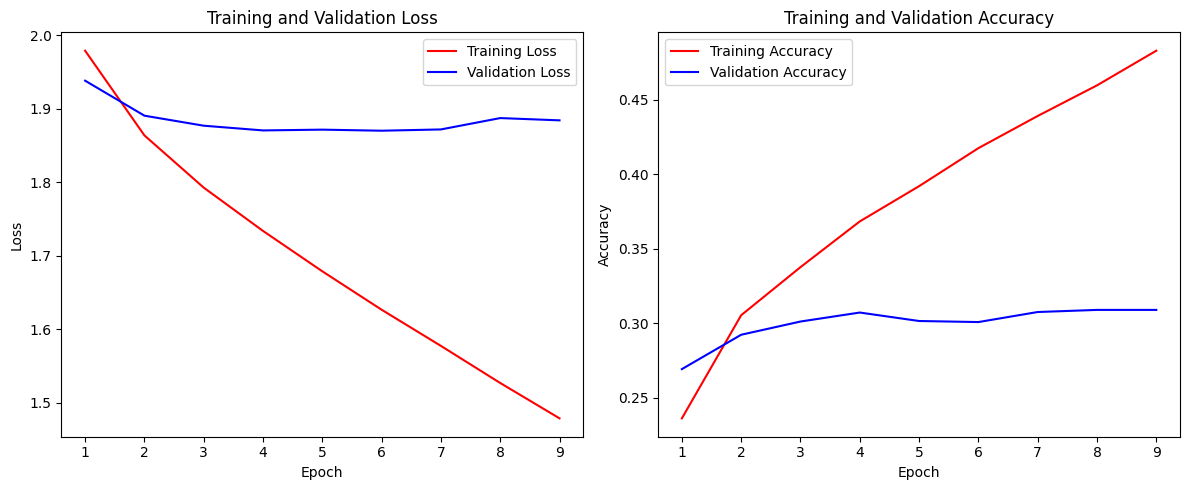

In [13]:
# Train the model
model, history = train_model(base_model, train_loader, val_loader, criterion, optimizer, epochs=14, device=device)

# Display the model summary
#print(summary(model, input_size=(batch_size, 3, input_shape[0], input_shape[1])))

# Save the trained model
torch.save(model.state_dict(), '/data/leuven/359/vsc35963/maibi_cv/Saved Model/model-affectnet3.pth')

In [12]:
# Define the function to calculate F1 score
def calculate_f1(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return f1_score(y_true, y_pred, average='weighted')

In [13]:
# Load the trained model
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[0].in_features, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, len(train_dataset.classes)),  # Ensure num_classes matches your number of classes
)

In [14]:
# Load the model weights
model.load_state_dict(torch.load('/data/leuven/359/vsc35963/maibi_cv/Saved Model/model-affectnet3.pth'))
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 3.379975849254565
Test Accuracy: 0.12015641663704231


In [16]:
# Calculate F1 score on the test dataset
f1score_test = calculate_f1(model, test_loader, device)
print(f"Test F1 Score: {f1score_test}")

Test F1 Score: 0.06452087857900948
